# Predecting Dangerous Junction Using ML
`This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether or not junction is dangerous for a specific person.`

**This notebook is organized into three main parts:**
> A.) `"Predicting Urban Intersection Risk with Machine Learning":`
In this section, I walk through the six essential steps I followed to develop the model, from understanding and preparing the data to evaluating the results. You can explore each step in detail or skip ahead to Section A.6 for a look at the model’s performance and early conclusions.

> B.) `"Insights and Visual Analysis":`
Here, you’ll find some additional insights on model performance and ways to interpret and apply the model's results.

> C.) `"Saving and Reusing the Model":`
The final part of the notebook covers how the trained model can be saved, reloaded, and reused—either for integration into an app or for further experimentation.

# A - walk through the six essential steps - Predicting Urban Intersection Risk
`This project is organized into a comprehensive data science workflow consisting of six steps`
<img src="images/workflow.png" alt="tools Image">




## A.1 – Problem Definition:

Predict how dangerous a specific urban intersection is, based on accident history and contextual factors (time, weather, driver demographics, etc.).
Goal: Produce a risk score or category that can help drivers anticipate danger before arriving at an intersection.

We plan to treat this as either:
- A **classification problem** (e.g., predicting risk level: low, medium, high)
- Or a **regression task** (e.g., predicting a continuous risk score)


## A.2 - Data 
The data used in this project was collected from the Israeli National Road Safety Authority (רלב"ד) for the year 2023. It consists of two official datasets:

Accident Data – Includes information about road accidents, such as accident location (intersections, road coordinates), time and date, severity, weather conditions, lighting, road type, and more.

Involved Persons Data – Contains demographic and behavioral details about each person involved in the accident, including role (driver/passenger/pedestrian), gender, age group, vehicle type, license issuance year, and injury details.

These datasets are linked using a shared accident ID (pk_teuna_fikt), which allows for merging and cross-referencing between accident-level and individual-level data.

### Load Data

In [1]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Statistical data visualization library

# We want our plots to appear inside the notebook
%matplotlib inline 

In [2]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
df_dataAcc = pd.read_csv("data/dataAcc.csv") 
df_dataAcc

,pk_teuna_fikt,sug_tik,THUM_GEOGRAFI,SUG_DEREH,SEMEL_YISHUV,REHOV1,REHOV2,BAYIT,ZOMET_IRONI,KVISH1,...,MEKOM_HAZIYA,KIVUN_HAZIYA,MAHOZ,NAFA,EZOR_TIVI,MAAMAD_MINIZIPALI,ZURAT_ISHUV,STATUS_IGUN,X,Y
0,2023000009,1,1,2,8600,719.0,NaN,104.0,NaN,NaN,...,0,9,5,51,512,0.0,14,1,183206.0,666306.0
1,2023000011,1,1,2,9700,NaN,NaN,9999.0,NaN,NaN,...,0,9,4,42,421,0.0,15,2,190185.0,673239.0
2,2023000013,1,1,2,8300,120.0,NaN,9999.0,NaN,NaN,...,0,9,4,44,442,0.0,13,3,179498.0,653490.0
3,2023000014,1,1,3,0,NaN,NaN,NaN,NaN,4.0,...,0,9,3,31,311,99.0,99,1,209195.0,751807.0
4,2023000021,1,1,2,3000,4121.0,NaN,9999.0,NaN,NaN,...,0,9,1,11,111,0.0,12,2,223381.0,633927.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8827,2023099950,1,1,2,3000,4763.0,NaN,2.0,NaN,NaN,...,0,9,1,11,111,0.0,12,3,221256.0,637964.0
8828,2023099951,1,1,2,5000,116.0,NaN,93.0,NaN,NaN,...,0,9,5,51,511,0.0,13,1,181474.0,669710.0
8829,2023099957,1,1,1,6600,751.0,736.0,NaN,11100356.0,NaN,...,3,9,5,51,513,0.0,14,1,178893.0,657953.0
8830,2023099981,1,1,4,0,NaN,NaN,NaN,NaN,4.0,...,0,9,5,51,512,99.0,99,1,185389.0,664592.0


**Filter to Urban Intersections**

In [4]:
# Count missing values in ZOMET_IRONI
missing_count = df_dataAcc['ZOMET_IRONI'].isna().sum()
total_rows = len(df_dataAcc)

print(f"Missing values in ZOMET_IRONI: {missing_count}/{total_rows}")


Missing values in ZOMET_IRONI: 6148/8832


In [5]:
# Filter rows where ZOMET_IRONI is not NaN
df_urban_intersections = df_dataAcc[df_dataAcc['ZOMET_IRONI'].notna()]
df_urban_intersections 


,pk_teuna_fikt,sug_tik,THUM_GEOGRAFI,SUG_DEREH,SEMEL_YISHUV,REHOV1,REHOV2,BAYIT,ZOMET_IRONI,KVISH1,...,MEKOM_HAZIYA,KIVUN_HAZIYA,MAHOZ,NAFA,EZOR_TIVI,MAAMAD_MINIZIPALI,ZURAT_ISHUV,STATUS_IGUN,X,Y
7,2023000040,1,1,1,6200,312.0,221.0,NaN,7810031.0,NaN,...,0,9,5,51,513,0.0,14,1,175748.0,657646.0
11,2023000059,1,1,1,7600,505.0,205.0,NaN,7620005.0,NaN,...,3,1,2,24,246,0.0,15,1,207762.0,759167.0
12,2023000073,1,1,1,6100,825.0,856.0,NaN,9520041.0,NaN,...,3,9,5,51,512,0.0,13,1,185084.0,665378.0
14,2023000076,1,1,1,70,715.0,704.0,NaN,8730052.0,NaN,...,0,9,6,61,613,0.0,13,1,166862.0,632180.0
19,2023000118,1,1,1,2600,372.0,384.0,NaN,8080004.0,NaN,...,0,9,6,62,625,0.0,15,1,193783.0,385959.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8819,2023099870,1,1,1,9500,207.0,124.0,NaN,7510005.0,NaN,...,0,9,3,31,311,0.0,16,1,208832.0,749078.0
8820,2023099879,1,1,1,5000,461.0,711.0,NaN,7700331.0,NaN,...,4,1,5,51,511,0.0,13,1,178331.0,665574.0
8822,2023099887,1,1,1,3000,1121.0,1093.0,NaN,92870888.0,NaN,...,0,9,1,11,111,0.0,12,1,217745.0,631262.0
8824,2023099916,1,1,1,3000,1863.0,1839.0,NaN,26330536.0,NaN,...,0,9,1,11,111,0.0,12,1,220351.0,628200.0


**Read the Inv Data**

In [6]:
df_dataInv = pd.read_csv("data/dataInv.csv") 
df_dataInv

,pk_teuna_fikt,MISPAR_REHEV_fikt,ZEHUT_fikt,SHNAT_TEUNA,HODESH_TEUNA,SUG_MEORAV,SHNAT_HOZAA,KVUZA_GIL,MIN,SUG_REHEV_NASA_LMS,...,PEULAT_NIFGA_LMS,KVUTZAT_OHLUSIYA_LMS,MAHOZ_MEGURIM,NAFA_MEGURIM,EZOR_TIVI_MEGURIM,MAAMAD_MINIZIPALI_MEGURIM,ZURAT_ISHUV_MEGURIM,SUG_TIK,ShimushBeAvizareyBetihut_LMS,PtiraMeuheret_LMS
0,2023000009,1,2,2023,4,2,2010,7,1,21.0,...,1,1,5.0,51,513.0,0.0,14.0,1,NaN,NaN
1,2023000009,2,1,2023,4,1,0,99,0,8.0,...,8,1,NaN,99,NaN,NaN,NaN,1,NaN,NaN
2,2023000011,0,2,2023,5,3,0,17,1,NaN,...,9,1,4.0,42,421.0,0.0,15.0,1,1.0,NaN
3,2023000011,1,1,2023,5,1,0,99,0,17.0,...,8,1,NaN,99,NaN,NaN,NaN,1,NaN,NaN
4,2023000013,1,2,2023,7,1,1985,13,1,11.0,...,8,1,4.0,43,432.0,0.0,15.0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22785,2023099957,0,2,2023,4,3,0,9,2,NaN,...,9,3,5.0,51,513.0,0.0,14.0,1,NaN,NaN
22786,2023099957,1,1,2023,4,1,1974,15,1,12.0,...,8,1,5.0,51,513.0,0.0,14.0,1,NaN,NaN
22787,2023099981,1,1,2023,5,2,2022,4,2,1.0,...,1,1,4.0,42,421.0,0.0,15.0,1,1.0,NaN
22788,2023099996,1,2,2023,8,2,2011,7,1,19.0,...,1,2,2.0,22,222.0,99.0,28.0,1,1.0,NaN



## A.3 – Success Criteria & Evaluation Goals

Before we dive into feature engineering, it's important to define what we expect from the model and how we plan to evaluate it.

Our goal is to predict how risky a specific urban intersection is, based on historical accident and contextual data.

We plan to treat this as either:
- A **classification problem** (e.g., predicting risk level: low, medium, high)
- Or a **regression task** (e.g., predicting a continuous risk score)

To evaluate our model, we’ll consider:
- For classification: **accuracy**, **precision**, **recall**, and **F1-score**
- For regression: **MAE**, **RMSE**, and **R² score**

As a rough benchmark, we aim for:
- Classification models: at least **80% accuracy**
- Regression models: reasonable **MAE or RMSE**, depending on the scale of the target

These goals will help us guide the modeling decisions in the next stages.


## A.4 - Features - what my data set is :
This is where you'll get different information about each of the features in your data. You can do this via doing your own research (such as looking at the links above) or by talking to a subject matter expert (someone who knows about the dataset).

Data dictonary below

### EDA (exploratory data analysis)
**The goal here is to find out more about the data and become a subject matter export on the dataset you're working with.**

1. What question(s) are you trying to solve?
2. What kind of data do we have and how do we treat different types?
3. What's missing from the data and how do you deal with it?
4. Where are the outliers and why should you care about them?
5. How can you add, change or remove features to get more out of your data?

#### Basics

****Distribution of Accidents by Day of the Week****

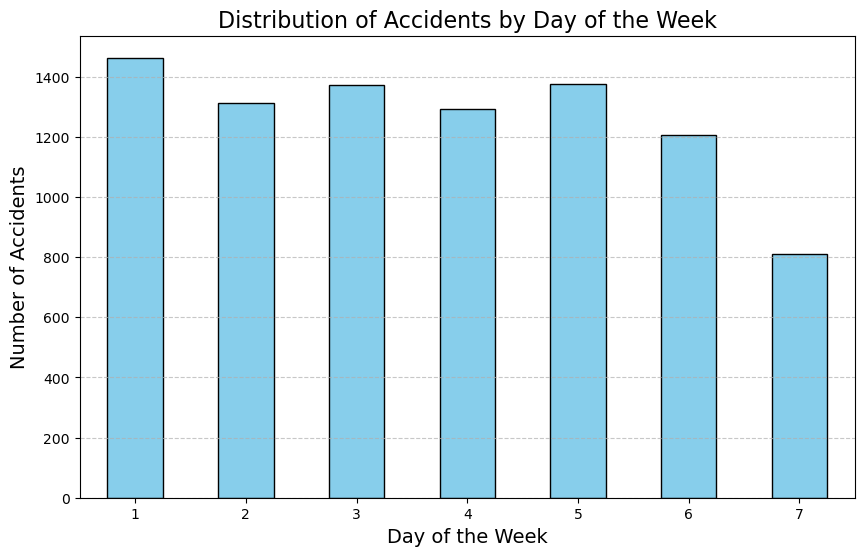

In [7]:
# Group by 'YOM_BASHAVUA' and count the number of accidents
accidents_by_day = df_dataAcc['YOM_BASHAVUA'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
accidents_by_day.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Accidents by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

****Accident Severity by Day of the Week****

In [8]:
pd.crosstab(df_dataAcc.YOM_BASHAVUA, df_dataAcc.HUMRAT_TEUNA)


HUMRAT_TEUNA,1,2,3
YOM_BASHAVUA,,,
1,56,363,1044
2,38,343,933
3,46,341,984
4,51,354,886
5,54,368,954
6,42,364,801
7,51,241,518


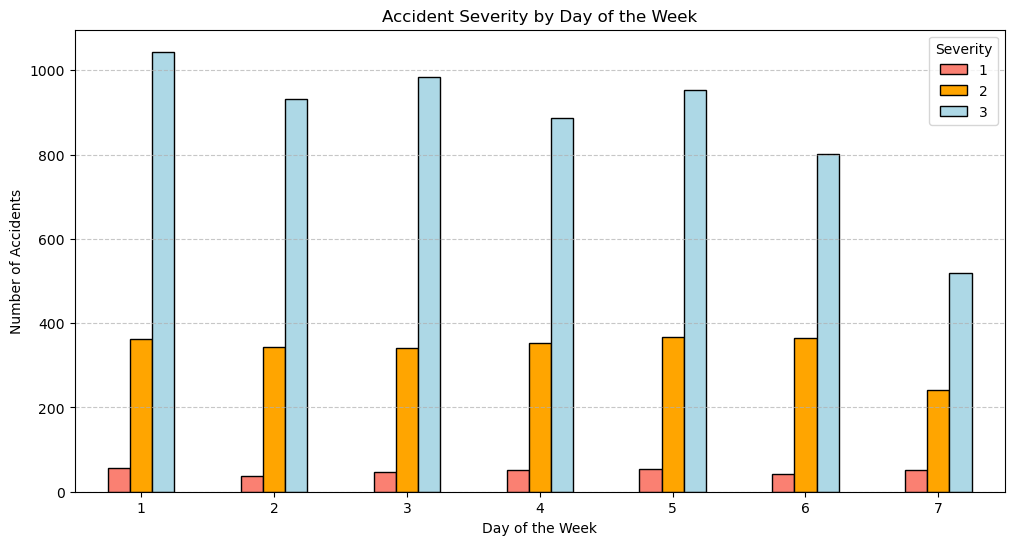

In [9]:
pd.crosstab(df_dataAcc['YOM_BASHAVUA'], df_dataAcc['HUMRAT_TEUNA']).plot(
    kind="bar", figsize=(12, 6), color=["salmon", "orange", "lightblue"] , edgecolor="black"
)
plt.title("Accident Severity by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Accidents")
plt.legend(title="Severity")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--",  alpha=0.7)
plt.show()


****top 10 coordinates with the most accidents****

In [10]:
# Group by coordinates (X, Y) and count the number of accidents
accidents_by_coordinates = df_dataAcc.groupby(['X', 'Y']).size().reset_index(name='num_accidents')

# Sort by the number of accidents in descending order
top_coordinates = accidents_by_coordinates.sort_values(by='num_accidents', ascending=False).head(10)

# Display the top 10 coordinates with the most accidents
top_coordinates


,X,Y,num_accidents
4630,208204.0,748966.0,26
572,176674.0,588820.0,17
4514,206994.0,739830.0,17
4325,204130.0,702897.0,16
4072,200809.0,685697.0,15
1228,179991.0,662972.0,12
5050,214504.0,714033.0,11
4667,208805.0,746687.0,11
4382,205020.0,712373.0,11
5021,214065.0,745761.0,11


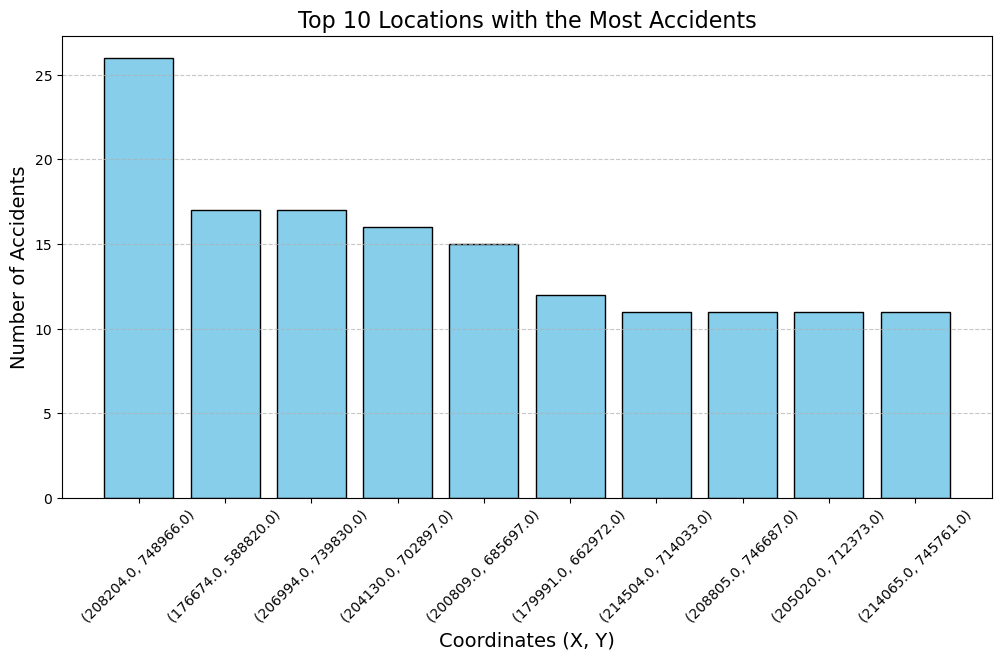

In [11]:
# Plot the top 10 coordinates with the most accidents
plt.figure(figsize=(12, 6))
plt.bar(
    top_coordinates.apply(lambda row: f"({row['X']}, {row['Y']})", axis=1),
    top_coordinates['num_accidents'],
    color="skyblue", edgecolor="black"
)
plt.title("Top 10 Locations with the Most Accidents", fontsize=16)
plt.xlabel("Coordinates (X, Y)", fontsize=14)
plt.ylabel("Number of Accidents", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



<img src="images/most_acc_overall.png" alt="most Image">

#### Intersections:


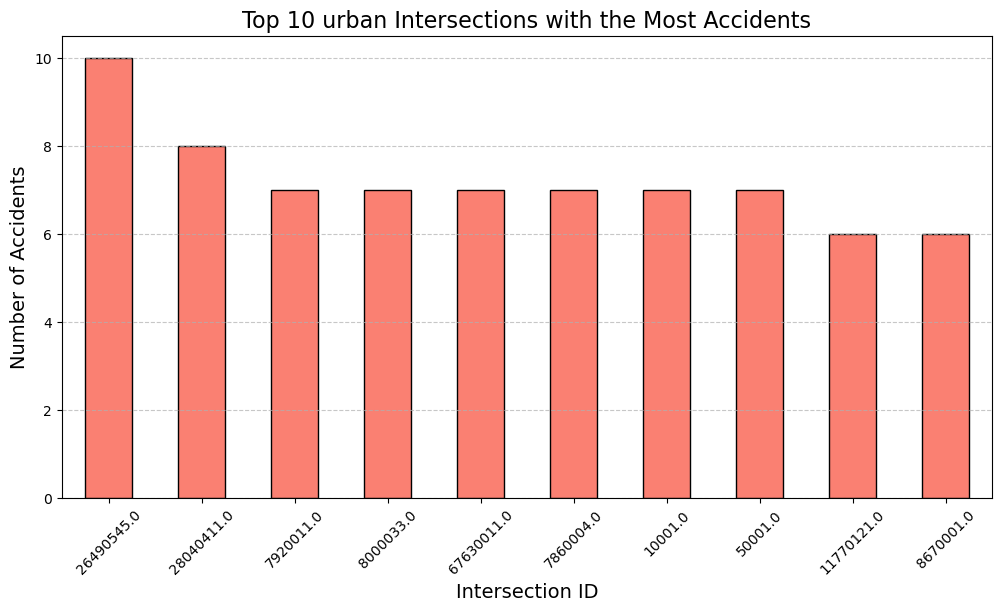

In [12]:
# Group by intersection (ZOMET_IRONI) and count the number of accidents
accidents_by_intersection = df_urban_intersections['ZOMET_IRONI'].value_counts()

# Plot the top 10 intersections with the most accidents
accidents_by_intersection.head(10).plot(kind="bar", figsize=(12, 6), color="salmon", edgecolor="black")
plt.title("Top 10 urban Intersections with the Most Accidents", fontsize=16)
plt.xlabel("Intersection ID", fontsize=14)
plt.ylabel("Number of Accidents", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



<img src="images/inter_with_most_acc.png" alt="most Image">

#### Cross the table

In [13]:
# Find common columns between the two DataFrames
common_columns = set(df_dataInv.columns).intersection(set(df_urban_intersections.columns))

# Print the common columns
print("Common columns:")
print(common_columns)


Common columns:
{'pk_teuna_fikt', 'HODESH_TEUNA', 'SHNAT_TEUNA'}


In [14]:

# Remove the specified columns from df_dataInv
df_dataInv = df_dataInv.drop(['SHNAT_TEUNA', 'HODESH_TEUNA'], axis=1)

# Check the updated DataFrame
print(f"Remaining columns: {df_dataInv.columns}")

Remaining columns: Index(['pk_teuna_fikt', 'MISPAR_REHEV_fikt', 'ZEHUT_fikt', 'SUG_MEORAV',
       'SHNAT_HOZAA', 'KVUZA_GIL', 'MIN', 'SUG_REHEV_NASA_LMS',
       'EMZAE_BETIHUT', 'SEMEL_YISHUV_MEGURIM', 'HUMRAT_PGIA', 'SUG_NIFGA_LMS',
       'PEULAT_NIFGA_LMS', 'KVUTZAT_OHLUSIYA_LMS', 'MAHOZ_MEGURIM',
       'NAFA_MEGURIM', 'EZOR_TIVI_MEGURIM', 'MAAMAD_MINIZIPALI_MEGURIM',
       'ZURAT_ISHUV_MEGURIM', 'SUG_TIK', 'ShimushBeAvizareyBetihut_LMS',
       'PtiraMeuheret_LMS'],
      dtype='object')


In [15]:
# Perform the merge
df_combined = pd.merge(
    df_urban_intersections,  # Left DataFrame
    df_dataInv,              # Right DataFrame
    on='pk_teuna_fikt',      # Common column to join on
    how='inner'              # Join type: 'inner' keeps only matching rows
)

# Display the resulting DataFrame

print(f"Number of rows: {df_combined.shape[0]}")


Number of rows: 6498


In [16]:
df_combined

,pk_teuna_fikt,sug_tik,THUM_GEOGRAFI,SUG_DEREH,SEMEL_YISHUV,REHOV1,REHOV2,BAYIT,ZOMET_IRONI,KVISH1,...,PEULAT_NIFGA_LMS,KVUTZAT_OHLUSIYA_LMS,MAHOZ_MEGURIM,NAFA_MEGURIM,EZOR_TIVI_MEGURIM,MAAMAD_MINIZIPALI_MEGURIM,ZURAT_ISHUV_MEGURIM,SUG_TIK,ShimushBeAvizareyBetihut_LMS,PtiraMeuheret_LMS
0,2023000040,1,1,1,6200,312.0,221.0,NaN,7810031.0,NaN,...,8,1,5.0,51,513.0,0.0,14.0,1,NaN,NaN
1,2023000040,1,1,1,6200,312.0,221.0,NaN,7810031.0,NaN,...,1,3,5.0,51,513.0,0.0,14.0,1,NaN,NaN
2,2023000059,1,1,1,7600,505.0,205.0,NaN,7620005.0,NaN,...,9,1,2.0,24,245.0,0.0,15.0,1,1.0,NaN
3,2023000059,1,1,1,7600,505.0,205.0,NaN,7620005.0,NaN,...,8,2,2.0,23,237.0,99.0,28.0,1,NaN,NaN
4,2023000073,1,1,1,6100,825.0,856.0,NaN,9520041.0,NaN,...,9,1,NaN,99,NaN,NaN,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6493,2023099887,1,1,1,3000,1121.0,1093.0,NaN,92870888.0,NaN,...,1,1,3.0,31,311.0,0.0,13.0,1,NaN,NaN
6494,2023099916,1,1,1,3000,1863.0,1839.0,NaN,26330536.0,NaN,...,1,1,7.0,74,740.0,73.0,19.0,1,NaN,NaN
6495,2023099916,1,1,1,3000,1863.0,1839.0,NaN,26330536.0,NaN,...,8,1,2.0,23,235.0,0.0,16.0,1,NaN,NaN
6496,2023099957,1,1,1,6600,751.0,736.0,NaN,11100356.0,NaN,...,9,3,5.0,51,513.0,0.0,14.0,1,NaN,NaN


In [18]:
# Filter rows where SUG_MEORAV is either 1 or 2
df_acc_inv_drivers = df_combined[df_combined['SUG_MEORAV'].isin([1, 2])]





df_acc_inv_drivers





,pk_teuna_fikt,sug_tik,THUM_GEOGRAFI,SUG_DEREH,SEMEL_YISHUV,REHOV1,REHOV2,BAYIT,ZOMET_IRONI,KVISH1,...,PEULAT_NIFGA_LMS,KVUTZAT_OHLUSIYA_LMS,MAHOZ_MEGURIM,NAFA_MEGURIM,EZOR_TIVI_MEGURIM,MAAMAD_MINIZIPALI_MEGURIM,ZURAT_ISHUV_MEGURIM,SUG_TIK,ShimushBeAvizareyBetihut_LMS,PtiraMeuheret_LMS
0,2023000040,1,1,1,6200,312.0,221.0,NaN,7810031.0,NaN,...,8,1,5.0,51,513.0,0.0,14.0,1,NaN,NaN
1,2023000040,1,1,1,6200,312.0,221.0,NaN,7810031.0,NaN,...,1,3,5.0,51,513.0,0.0,14.0,1,NaN,NaN
3,2023000059,1,1,1,7600,505.0,205.0,NaN,7620005.0,NaN,...,8,2,2.0,23,237.0,99.0,28.0,1,NaN,NaN
5,2023000073,1,1,1,6100,825.0,856.0,NaN,9520041.0,NaN,...,8,1,5.0,51,512.0,0.0,13.0,1,NaN,NaN
6,2023000076,1,1,1,70,715.0,704.0,NaN,8730052.0,NaN,...,1,3,6.0,61,613.0,0.0,13.0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,2023099887,1,1,1,3000,1121.0,1093.0,NaN,92870888.0,NaN,...,1,1,1.0,11,111.0,0.0,12.0,1,NaN,NaN
6492,2023099887,1,1,1,3000,1121.0,1093.0,NaN,92870888.0,NaN,...,1,1,1.0,11,111.0,0.0,12.0,1,1.0,NaN
6494,2023099916,1,1,1,3000,1863.0,1839.0,NaN,26330536.0,NaN,...,1,1,7.0,74,740.0,73.0,19.0,1,NaN,NaN
6495,2023099916,1,1,1,3000,1863.0,1839.0,NaN,26330536.0,NaN,...,8,1,2.0,23,235.0,0.0,16.0,1,NaN,NaN


In [19]:
# Check the distribution of SUG_MEORAV
print(df_acc_inv_drivers['SUG_MEORAV'].value_counts(normalize=True))


SUG_MEORAV
2    0.509311
1    0.490689
Name: proportion, dtype: float64


#### Plot form the driver table

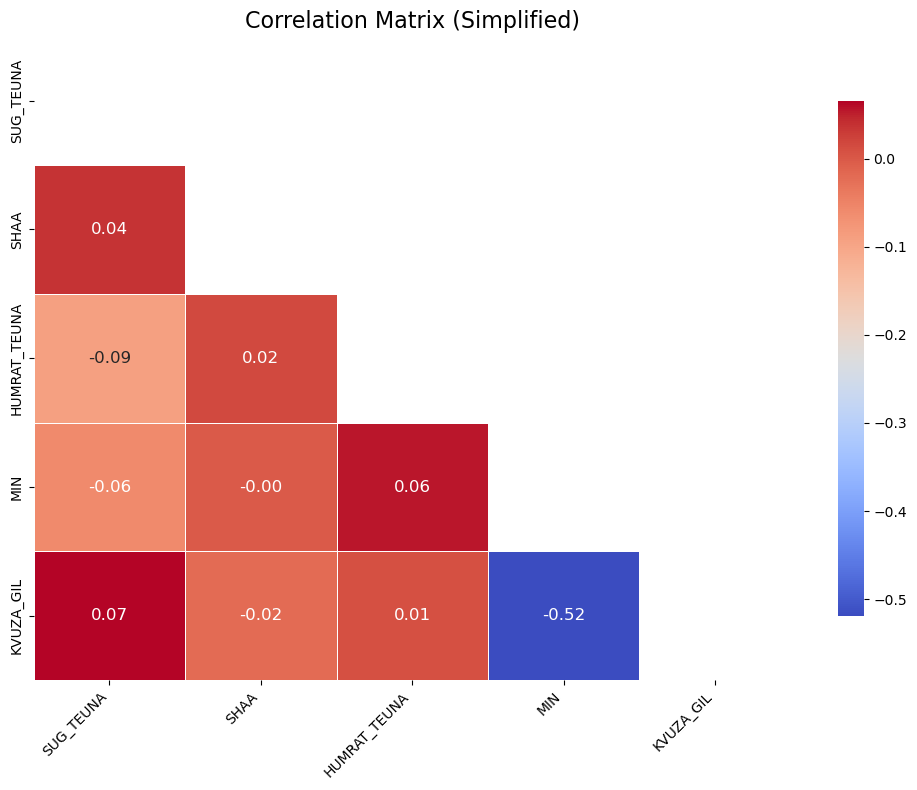

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select only relevant numeric columns
selected_columns = ['SUG_TEUNA', 'SHAA', 'HUMRAT_TEUNA', 'MIN' , 'KVUZA_GIL']  # Example columns
numeric_cols = df_acc_inv_drivers[selected_columns]

# Step 2: Compute the correlation matrix
corr_matrix = numeric_cols.corr()

# Step 3: Mask the upper triangle for clarity
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Step 4: Plot the heatmap
plt.figure(figsize=(10, 8))  # Set plot size
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
            linewidths=0.5, cbar_kws={"shrink": 0.8}, annot_kws={"size": 12})

# Step 5: Add titles and format
plt.title("Correlation Matrix (Simplified)", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


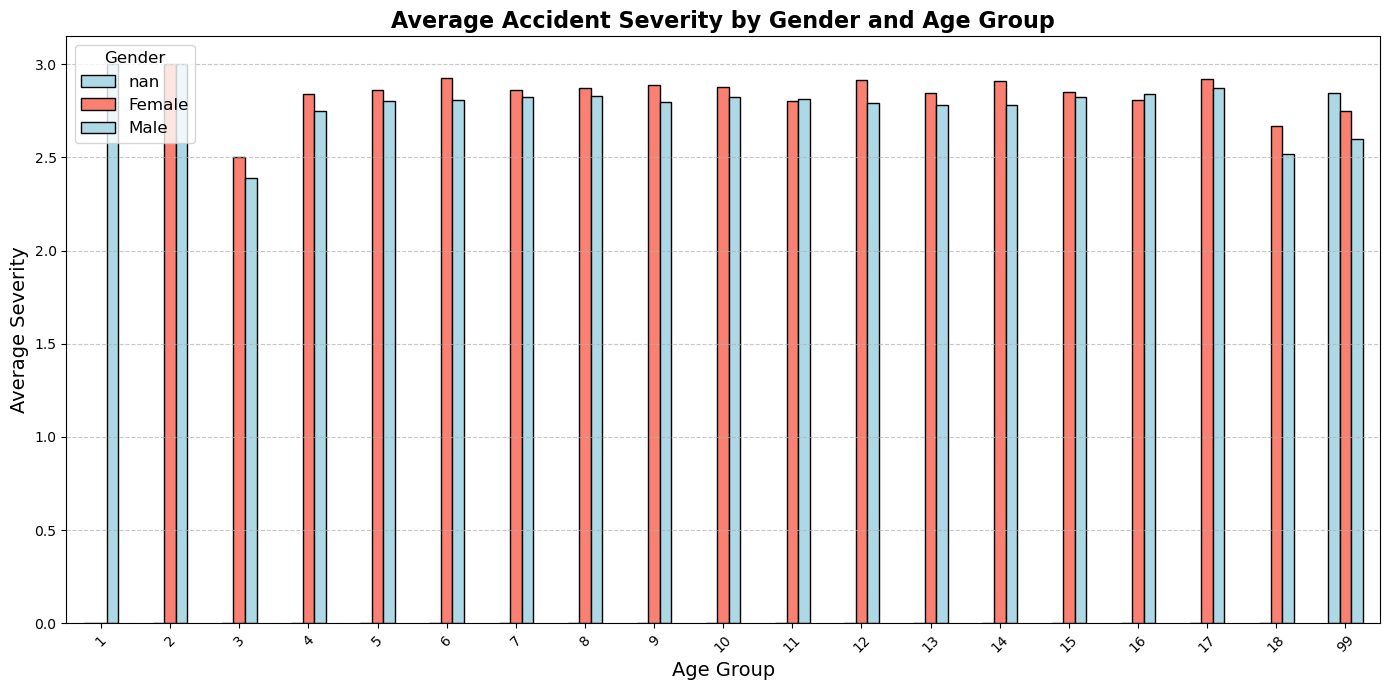

In [21]:
# Step 1: Group the data by 'MIN' (Gender) and 'KVUZA_GIL' (Age Group)
grouped_data = df_acc_inv_drivers.groupby(['MIN', 'KVUZA_GIL'])['HUMRAT_TEUNA'].mean().reset_index()

# Step 2: Rename the columns for better readability
grouped_data.columns = ['Gender', 'Age Group', 'Average Severity']

# Step 3: Map Gender for readability (1 = Male, 2 = Female)
grouped_data['Gender'] = grouped_data['Gender'].map({1: 'Male', 2: 'Female'})

# Step 4: Use a Crosstab-like Aggregation and Bar Plot
pivot_table = grouped_data.pivot(index='Age Group', columns='Gender', values='Average Severity')

# Step 5: Plot the data
pivot_table.plot(kind='bar', figsize=(14, 7), color=["lightblue", "salmon"], edgecolor="black")

# Step 6: Add titles and labels
plt.title('Average Accident Severity by Gender and Age Group', fontsize=16, weight='bold')
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Average Severity', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Gender", fontsize=12, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Step 7: Show the plot
plt.tight_layout()
plt.show()


C:\Users\itama\AppData\Local\Temp\ipykernel_8488\2677564178.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


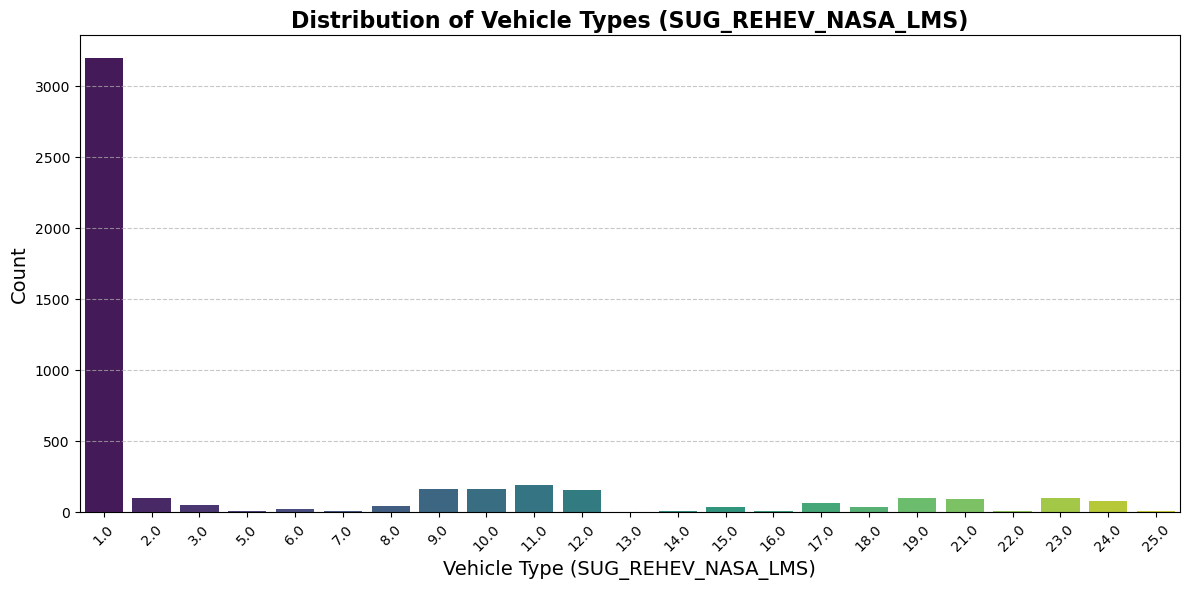

In [22]:
# Step 1: Count occurrences of each vehicle type
vehicle_counts = df_acc_inv_drivers['SUG_REHEV_NASA_LMS'].value_counts()

# Step 2: Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x=vehicle_counts.index, 
    y=vehicle_counts.values, 
    palette="viridis"
)

# Step 3: Add titles and labels
plt.title('Distribution of Vehicle Types (SUG_REHEV_NASA_LMS)', fontsize=16, weight='bold')
plt.xlabel('Vehicle Type (SUG_REHEV_NASA_LMS)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Step 4: Show the plot
plt.tight_layout()
plt.show()

## A.4.1 - Features - Prepering the table for Modeling

### Creating the Target Using Our Own Formula:

In [23]:
# 1. Load the dataset
df = pd.read_csv("data/df_acc_inv_drivers.csv")

# 2. Create a severity score based on accident severity (1=fatal, 2=serious, 3=light)
severity_mapping = {1: 3, 2: 2, 3: 1}
df['severity_score'] = df['HUMRAT_TEUNA'].map(severity_mapping)

# 3. Calculate the severity component: score × 2
df['component_1'] = df['severity_score'] * 2

# 4. Group by intersection (urban intersection + town code)
intersection_group = df.groupby(['ZOMET_IRONI', 'SEMEL_YISHUV'])

# 5. For each intersection, count total accidents and how many were fatal, severe, and light
acc_stats = intersection_group['HUMRAT_TEUNA'].agg(
    total_acc='count',                         # total number of accidents
    fatal_acc=lambda x: (x == 1).sum(),         # number of fatal accidents
    severe_acc=lambda x: (x == 2).sum(),        # number of severe accidents
    light_acc=lambda x: (x == 3).sum()          # number of light accidents
).reset_index()

# 6. Calculate ratios and normalize by the intersection with the most accidents
max_total_acc = acc_stats['total_acc'].max()
acc_stats['fatal_ratio'] = (acc_stats['fatal_acc'] / max_total_acc).round(2)
acc_stats['severe_ratio'] = (acc_stats['severe_acc'] / max_total_acc).round(2)
acc_stats['light_ratio'] = (acc_stats['light_acc'] / max_total_acc).round(2)
acc_stats['volume_ratio'] = (acc_stats['total_acc'] / max_total_acc).round(2)            # normalized accident volume

# 7. Merge the stats back into the main dataframe
df = df.merge(acc_stats, on=['ZOMET_IRONI', 'SEMEL_YISHUV'], how='left')

# 7.5. Create a new base risk score based on all accident types and volume
df['base_risk_score'] = (
    df['fatal_ratio'] * 15 +        # high weight for fatality
    df['severe_ratio'] * 8 +         # medium weight for severe accidents
    df['light_ratio'] * 2 +          # lower weight for light accidents
    df['volume_ratio'] * 10          # very high weight for accident volume
).round(2)  # Round the base risk score to 2 decimal places

# 8. Calculate the final hybrid risk score including accident-specific severity
df['risk_score_per_row'] = (
    df['component_1'] + 
    df['base_risk_score']
).round(2)  # Round the final risk score per row

# 9. Save the new dataframe with the updated risk scores (optional)
#df.to_csv("df_with_risk_score.csv", index=False)


### Prepering our data for ML model:

In [24]:
# 2. Load the ready dataset
# ====================================

# Load the dataset we previously created
df = pd.read_csv('data/df_with_risk_score.csv')  # adjust path if needed

# ====================================
# 3. Select only the relevant columns we need for modeling
# ====================================

columns_to_keep = [
    # General identification
    'ZOMET_IRONI', 'SEMEL_YISHUV', 'X', 'Y',
    
    # Time and Date features
    'SHNAT_TEUNA', 'HODESH_TEUNA', 'SHAA', 'SUG_YOM', 'YOM_LAYLA', 'YOM_BASHAVUA',
    
    # Road characteristics
    'SUG_DEREH', 'ZURAT_DEREH', 'HAD_MASLUL', 'RAV_MASLUL', 'MEHIRUT_MUTERET',
    'TKINUT', 'ROHAV', 'SIMUN_TIMRUR', 'TEURA', 'RAMZOR',
    
    # Environmental conditions
    'BAKARA', 'MEZEG_AVIR', 'PNE_KVISH',
    
    # Demographic location
    'NAFA',
    
    # Driver features
    'KVUZA_GIL', 'MIN',
    
    # Target
    'base_risk_score'
]

# Keep only the selected columns
df_clean = df[columns_to_keep].copy()

# ====================================
# 4. Create a new feature: veteran_driver_years
# ====================================

# If SHNAT_HOZAA (license issue year) exists, calculate driver experience
if 'SHNAT_HOZAA' in df.columns:
    # Replace SHNAT_HOZAA equal to 0 or 2025 with NaN to avoid unrealistic experience calculation
    df['SHNAT_HOZAA'] = df['SHNAT_HOZAA'].replace([0, 2025], np.nan)
    
    # Calculate driver experience (veteran_driver_years)
    df_clean['veteran_driver_years'] = (2025 - df['SHNAT_HOZAA']).clip(lower=0)
else:
    # If SHNAT_HOZAA is not available, fill veteran_driver_years with None
    df_clean['veteran_driver_years'] = None

# ====================================
# 5. Final review
# ====================================

# Display the first few rows to check
df_clean.head()

# ====================================
# 6. (Optional) Save the cleaned dataset
# ====================================

# Save if you want to have a clean version for the model training
# df_clean.to_csv('data/df_for_model.csv', index=False)
df_clean.head()

,ZOMET_IRONI,SEMEL_YISHUV,X,Y,SHNAT_TEUNA,HODESH_TEUNA,SHAA,SUG_YOM,YOM_LAYLA,YOM_BASHAVUA,...,TEURA,RAMZOR,BAKARA,MEZEG_AVIR,PNE_KVISH,NAFA,KVUZA_GIL,MIN,base_risk_score,veteran_driver_years
0,7810031.0,6200,175748.0,657646.0,2023,1,40,4,1,1,...,1,1,2.0,1,1,51,10,2,1.32,8.0
1,7810031.0,6200,175748.0,657646.0,2023,1,40,4,1,1,...,1,1,2.0,1,1,51,7,1,1.32,8.0
2,7620005.0,7600,207762.0,759167.0,2023,3,54,4,1,5,...,1,0,1.0,1,1,24,9,1,0.60,25.0
3,9520041.0,6100,185084.0,665378.0,2023,5,74,4,1,2,...,1,0,1.0,1,1,51,5,1,0.60,3.0
4,8730052.0,70,166862.0,632180.0,2023,9,54,4,1,2,...,1,0,6.0,1,1,61,8,2,2.52,5.0


### Prepering 2.0 Cleaned the data and orgnaized:

In [25]:
df_model = pd.read_csv('data/df_clean_data_for_model.csv') 
df_model
# after that we dlete few cols


,HODESH_TEUNA,SHAA,SUG_YOM,YOM_LAYLA,YOM_BASHAVUA,SUG_DEREH,ZURAT_DEREH,HAD_MASLUL,RAV_MASLUL,MEHIRUT_MUTERET,...,TEURA,RAMZOR,BAKARA,MEZEG_AVIR,PNE_KVISH,NAFA,KVUZA_GIL,MIN,base_risk_score,veteran_driver_years
0,1,40,4,1,1,1,8,0,3,1,...,1,1,2.0,1,1,51,10,2,1.32,8.0
1,1,40,4,1,1,1,8,0,3,1,...,1,1,2.0,1,1,51,7,1,1.32,8.0
2,3,54,4,1,5,1,8,1,0,1,...,1,0,1.0,1,1,24,9,1,0.60,25.0
3,5,74,4,1,2,1,8,1,0,1,...,1,0,1.0,1,1,51,5,1,0.60,3.0
4,9,54,4,1,2,1,8,3,0,1,...,1,0,6.0,1,1,61,8,2,2.52,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613,7,64,4,1,1,1,8,3,0,1,...,1,1,2.0,1,1,11,8,1,3.84,19.0
4614,7,64,4,1,1,1,8,3,0,1,...,1,1,2.0,1,1,11,13,2,3.84,47.0
4615,3,33,4,1,4,1,9,1,0,1,...,11,1,3.0,2,1,11,5,2,1.32,7.0
4616,3,33,4,1,4,1,9,1,0,1,...,11,1,3.0,2,1,11,13,1,1.32,44.0


In [26]:
# Convert SHAA from quarter-hour intervals (1-96) to standard hour (0-23)
df_model['HOUR'] = ((df_model['SHAA'] - 1) // 4).astype(int)
# After checking, we can optionally drop the original 'SHAA' column
df_model.drop(columns=['SHAA'], inplace=True)
df_model



,HODESH_TEUNA,SUG_YOM,YOM_LAYLA,YOM_BASHAVUA,SUG_DEREH,ZURAT_DEREH,HAD_MASLUL,RAV_MASLUL,MEHIRUT_MUTERET,TKINUT,...,RAMZOR,BAKARA,MEZEG_AVIR,PNE_KVISH,NAFA,KVUZA_GIL,MIN,base_risk_score,veteran_driver_years,HOUR
0,1,4,1,1,1,8,0,3,1,1,...,1,2.0,1,1,51,10,2,1.32,8.0,9
1,1,4,1,1,1,8,0,3,1,1,...,1,2.0,1,1,51,7,1,1.32,8.0,9
2,3,4,1,5,1,8,1,0,1,1,...,0,1.0,1,1,24,9,1,0.60,25.0,13
3,5,4,1,2,1,8,1,0,1,1,...,0,1.0,1,1,51,5,1,0.60,3.0,18
4,9,4,1,2,1,8,3,0,1,1,...,0,6.0,1,1,61,8,2,2.52,5.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613,7,4,1,1,1,8,3,0,1,1,...,1,2.0,1,1,11,8,1,3.84,19.0,15
4614,7,4,1,1,1,8,3,0,1,1,...,1,2.0,1,1,11,13,2,3.84,47.0,15
4615,3,4,1,4,1,9,1,0,1,1,...,1,3.0,2,1,11,5,2,1.32,7.0,8
4616,3,4,1,4,1,9,1,0,1,1,...,1,3.0,2,1,11,13,1,1.32,44.0,8


**Keep WOrking with df_model as data/df_for_model_final.csv from now on...**

In [31]:
# df_model.to_csv('data/df_for_model_final.csv', index=False)
df_model = pd.read_csv('data/df_for_model_final.csv')
df_model

,HODESH_TEUNA,SUG_YOM,YOM_LAYLA,YOM_BASHAVUA,SUG_DEREH,ZURAT_DEREH,HAD_MASLUL,RAV_MASLUL,MEHIRUT_MUTERET,TKINUT,...,RAMZOR,BAKARA,MEZEG_AVIR,PNE_KVISH,NAFA,KVUZA_GIL,MIN,base_risk_score,veteran_driver_years,HOUR
0,1,4,1,1,1,8,0,3,1,1,...,1,2.0,1,1,51,10,2,1.32,8.0,9
1,1,4,1,1,1,8,0,3,1,1,...,1,2.0,1,1,51,7,1,1.32,8.0,9
2,3,4,1,5,1,8,1,0,1,1,...,0,1.0,1,1,24,9,1,0.60,25.0,13
3,5,4,1,2,1,8,1,0,1,1,...,0,1.0,1,1,51,5,1,0.60,3.0,18
4,9,4,1,2,1,8,3,0,1,1,...,0,6.0,1,1,61,8,2,2.52,5.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613,7,4,1,1,1,8,3,0,1,1,...,1,2.0,1,1,11,8,1,3.84,19.0,15
4614,7,4,1,1,1,8,3,0,1,1,...,1,2.0,1,1,11,13,2,3.84,47.0,15
4615,3,4,1,4,1,9,1,0,1,1,...,1,3.0,2,1,11,5,2,1.32,7.0,8
4616,3,4,1,4,1,9,1,0,1,1,...,1,3.0,2,1,11,13,1,1.32,44.0,8


## A.5 - Modelling

## A.6 - Experimentation

# B - Define the Prediction Function - Insights and Analysis
<img src="images/visual.jpg" alt="tools Image">